In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.utils as utils

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.vae_lstm import LSTMVAE
from src.vae_dense import DenseVAE, ImprovedDenseVAE
from src.vae_conv import ConvVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib
import tensorflow as tf
import mlflow

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

tf.keras.utils.set_random_seed(42)

2024-01-13 15:16:32.972302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Hyperparams

In [3]:
# HYPERPARAMS
N_EPOCHS: int = 64
N_BATCHES: int = 4
VAL_SPLIT: float = 0.2
DROPOUT_RATE: float = 0.0           # Only for DenseVAE
RECONSTRUCTION_WEIGHT: int = 3      # Weight of reconstruction_loss in total_loss metric

# Size of the latent dimension
LATENT_DIM: int = 10

# Settings to save model and history / comparison plots
SAVE_MODEL: bool = False     # If set to true, model will be saved under ../models/ dir
MODEL_ID: str = utils.get_model_id(N_EPOCHS, N_BATCHES, VAL_SPLIT, LATENT_DIM)

# Load Data

In [4]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2024-01-13 15:16:40,218 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2024-01-13 15:16:47,785 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [5]:
CONDITIONS = ["MathxEasy", "MathxMedium", "MathxHard"]
pp_data = {}

for i, condition in enumerate(CONDITIONS):
    preprocessor = Preprocesser(df_list=df_list, condition=condition, partition_size=250, fixed_size=11000)
    tensor: np.array = preprocessor.preprocess_data()
    FEATURE_NAMES = list(preprocessor.df_list_processed[0].columns)

    pp_data[condition] = {
        "tensor": tensor,
        "y_list": preprocessor.y_list_processed,
        "condition": condition,
        "condition_encoded": i,
        "condition_df": pd.DataFrame([condition for n in range(0, tensor.shape[0])]),
        "condition_encoded_df": pd.DataFrame([i for n in range(0, tensor.shape[0])]),
        "feature_names": FEATURE_NAMES,
        "scaler_object": preprocessor.scaler
    }


2024-01-13 15:16:47,894 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxEasy, Partition Size: 250, Fixed Size: 11000) ...
2024-01-13 15:16:48,126 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-13 15:16:48,139 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.24s) ...

2024-01-13 15:16:48,142 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxMedium, Partition Size: 250, Fixed Size: 11000) ...
2024-01-13 15:16:48,357 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-13 15:16:48,370 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.23s) ...

2024-01-13 15:16:48,371 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Partition Size: 250, Fixed Size: 11000) ...
2024-01-13 15:16:48,581 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-13 15:16:48,593 - src.preprocessing - INFO - Finished preprocessin

In [6]:
# Stack data of each condition to one single 3D numpy array (input data to model)
tensor = np.concatenate([pp_data[key]["tensor"] for key in pp_data.keys()], axis=0)
y_tensor = np.concatenate([pp_data[key]["y_list"] for key in pp_data.keys()], axis=0)
conditions = pd.concat(pp_data[key]["condition_df"] for key in pp_data.keys())

In [7]:
# Get Labels in Shape (1290 x 1), i.e. (Number of Samples, Dimension_Label)
y_label_list = []
for i in range(0, y_tensor.shape[0]):
    y = y_tensor[i][0]
    y_label_list.append(y)
y_label = np.array(y_label_list)

# Discretize labels
def _discretize_target(val: float) -> np.array:
    """ Call this function via np.vectorize(_discretize_target)(y_label) """
    if val < 0.1:
        return 0
    elif 0.1 <= val < 0.3:
        return 1
    else:
        return 2

classes = np.vectorize(_discretize_target)(y_label)

In [8]:
print(f"Shape of Input Data: {tensor.shape}")
print(f"Shape of condition_df: {conditions.shape}")
print(f"Shape of Labels: {y_tensor.shape}")
print(f"Shape of discretized labels: {classes.shape}")

Shape of Input Data: (1320, 250, 7)
Shape of condition_df: (1320, 1)
Shape of Labels: (1320, 250, 1)
Shape of discretized labels: (1320, 1)


# Modelling

In [42]:
#vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT)
vae = DenseVAE(tensor=tensor, latent_dims=LATENT_DIM,
               reconstruction_weight=RECONSTRUCTION_WEIGHT, dropout_rate = DROPOUT_RATE, activation="elu")
#vae = ImprovedDenseVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT, dropout_rate = DROPOUT_RATE)
#vae = ConvVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT)

vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

In [43]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 250, 7)]             0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 1750)                 0         ['input_3[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 512)                  896512    ['flatten_1[0][0]']           
                                                                                                  
 dropout_6 (Dropout)         (None, 512)                  0         ['dense_10[0][0]']            
                                                                                            

In [44]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_15 (Dense)            (None, 32)                352       
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               3302

In [45]:
mlflow.tensorflow.autolog(log_models=False)

history = vae.fit(tensor, epochs=N_EPOCHS, batch_size=N_BATCHES,
                  validation_split=VAL_SPLIT, shuffle=True)#,
                  #callbacks=[ReduceLROnPlateau(monitor="val_loss", patience=7), EarlyStopping(monitor="val_loss", patience=12)])

2024/01/13 15:26:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6187f7d3b96445baba661193285a4015', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/01/13 15:26:36 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "dense_vae_1" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.


Epoch 1/64
  5/264 [..............................] - ETA: 4s - loss: 920.3239 - reconstruction_loss: 230.8871 - kl_loss: 31.7837  

2024-01-13 15:26:40,278 - tensorflow - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


264/264 [==============================] - 7s 17ms/step - loss: 154.2011 - reconstruction_loss: 26.4599 - kl_loss: 11.2205 - val_loss: 71.6428 - val_reconstruction_loss: 12.5041 - val_kl_loss: 34.1304
Epoch 2/64
264/264 [==============================] - 4s 17ms/step - loss: 60.0791 - reconstruction_loss: 17.0347 - kl_loss: 7.3702 - val_loss: 62.7060 - val_reconstruction_loss: 13.5891 - val_kl_loss: 21.9388
Epoch 3/64
264/264 [==============================] - 3s 13ms/step - loss: 52.0131 - reconstruction_loss: 15.1361 - kl_loss: 6.0492 - val_loss: 53.7736 - val_reconstruction_loss: 11.7864 - val_kl_loss: 18.4144
Epoch 4/64
264/264 [==============================] - 4s 14ms/step - loss: 49.5474 - reconstruction_loss: 14.9255 - kl_loss: 5.0611 - val_loss: 49.7976 - val_reconstruction_loss: 12.0887 - val_kl_loss: 13.5314
Epoch 5/64
264/264 [==============================] - 4s 17ms/step - loss: 48.4400 - reconstruction_loss: 14.5343 - kl_loss: 4.6448 - val_loss: 45.0163 - val_reconstruct

# Save Model

In [46]:
if SAVE_MODEL:
    # Do a forward pass once to allow saving ...
    x = vae.predict(np.expand_dims(tensor[0], axis=0))

    print(f"Saving Model as '{MODEL_ID}' in models/ dir")
    vae.save(f"../models/{MODEL_ID}")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Analyse History

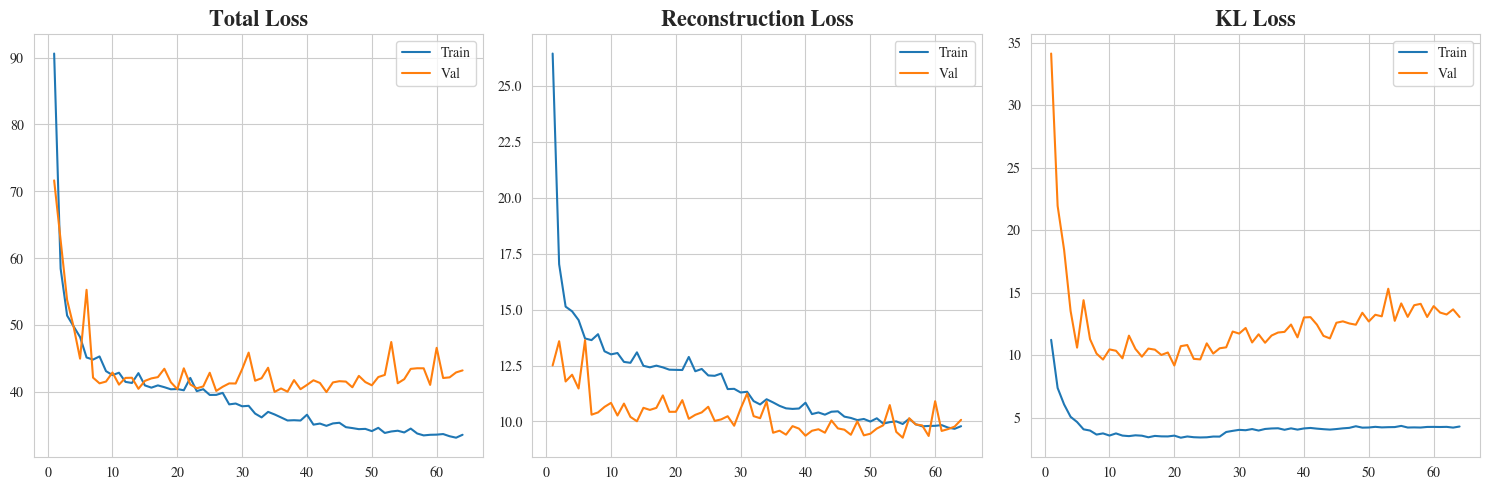

In [47]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved History in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/history.png")


plot_history(history)

# Reconstruction Plotting

In [48]:
SAMPLE_IDX_TO_VISUALIZE: int = 430

train_sample = np.expand_dims(tensor[SAMPLE_IDX_TO_VISUALIZE], axis=0)
train_sample_condition = conditions.iloc[SAMPLE_IDX_TO_VISUALIZE, 0]
print(f"Shape of train_sample to visualize: {train_sample.shape} with condition '{train_sample_condition}'")

Shape of train_sample to visualize: (1, 250, 7) with condition 'MathxEasy'


In [49]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 0s 177ms/step


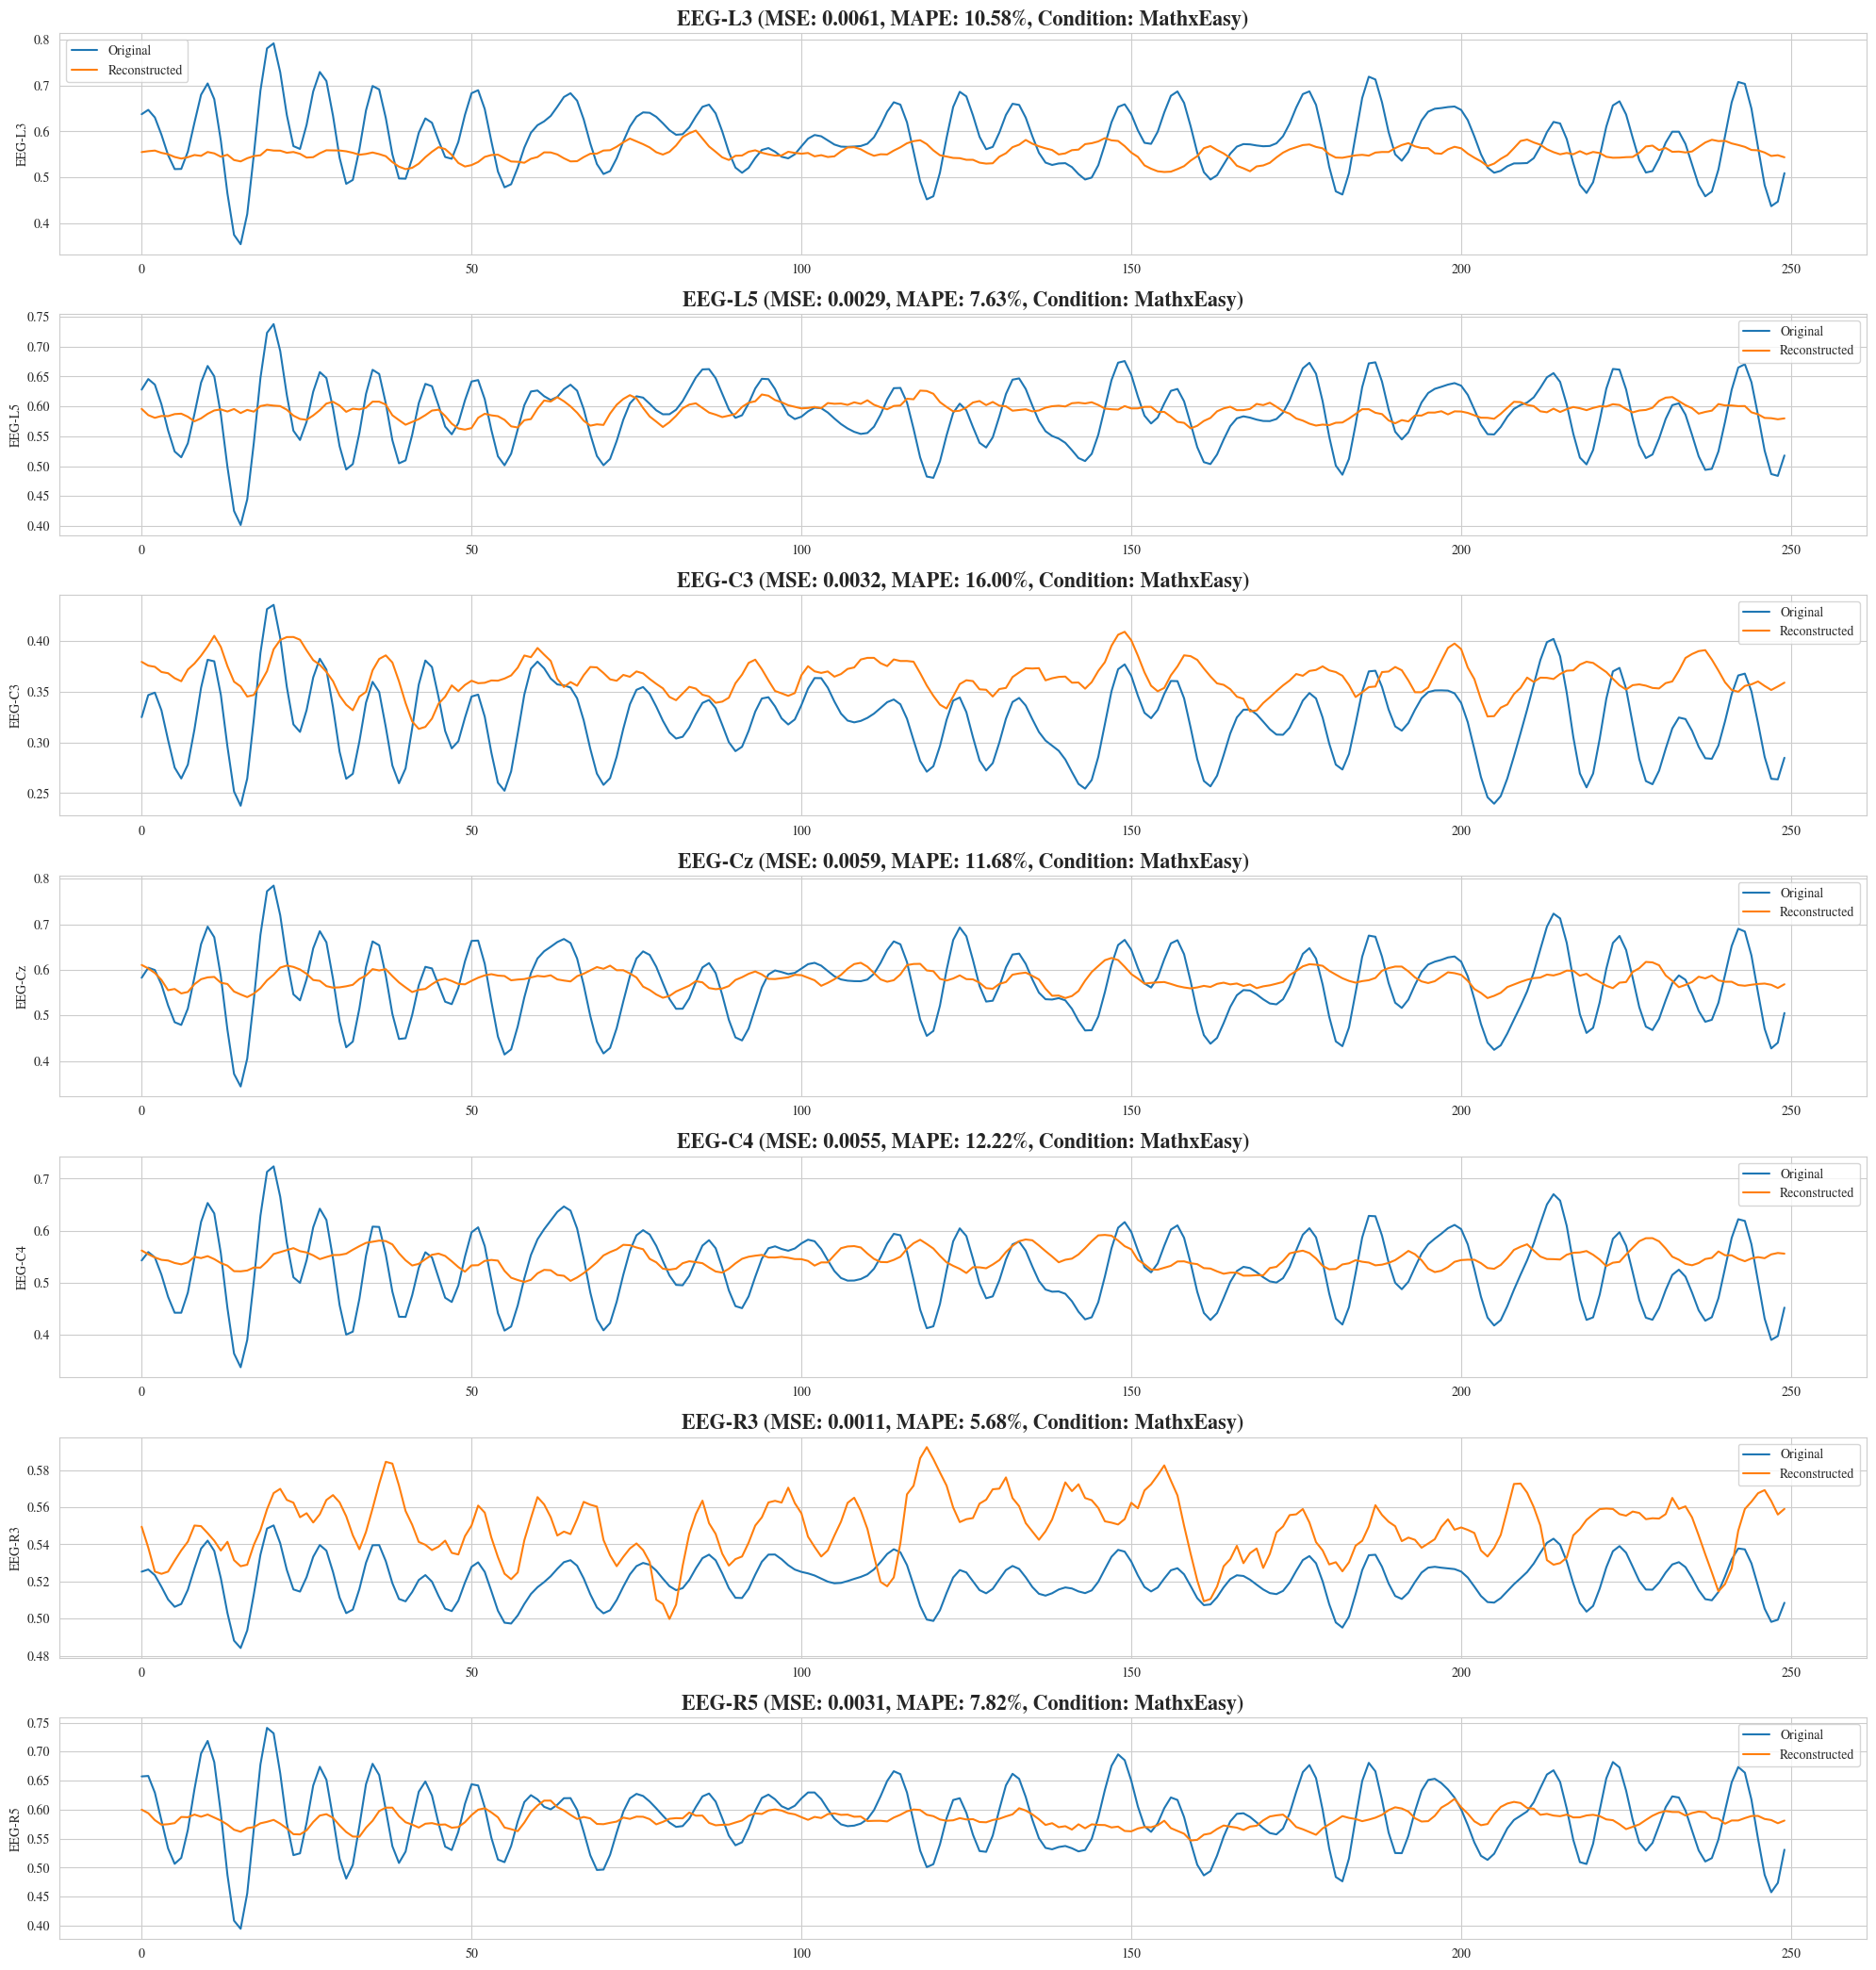

In [50]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array, condition: str) -> None:
    # Compute MSE and MAPE along the rows, for each column
    mse = np.mean(((train_sample[0] - train_sample_reconstructed[0])**2), axis=0)
    mape = np.mean(np.abs((train_sample[0] - train_sample_reconstructed[0]) / train_sample[0]), axis=0) * 100

    # Convert to pd.DataFrame for plotting reasons
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for i, (col, ax) in enumerate(zip(FEATURE_NAMES, axes.flatten())):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(f"{col} (MSE: {mse[i]:.4f}, MAPE: {mape[i]:.2f}%, Condition: {condition})", fontweight="bold", size=16)
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved Comparison in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/comparison.png")


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0], condition=train_sample_condition)

# Generate new Samples by Sampling from latent space

In [51]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

def sample_from_prior_z(num_samples: int, latent_dims: int):
    z = np.random.normal(size=(num_samples, latent_dims))
    return z

def get_samples_given_z(z):
    samples = vae.decoder(z).numpy()
    return samples

# Generate synthetic time series data
num_samples = 1
#synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
synthetic_time_series = get_samples_given_z(sample_from_prior_z(num_samples, LATENT_DIM))
print(synthetic_time_series.shape)

(1, 250, 7)


In [52]:
def plot_all_time_series(X: np.array) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param x: np.array -- Input data of shape (N_SEQ, N_FEATS)
    :param time_col: str -- Name of the time column
    :return: None
    """
    df = pd.DataFrame(X, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(20, len(df.columns)*3))
    for col, ax in zip(df.columns, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

#plot_all_time_series(synthetic_time_series[0])

# Visualize latent space / posterior
$$ q_\Phi(z|x) \approx p\theta(z|x) $$

In [53]:
def encode_batch(x: np.array):
    z_mean, z_log_var, z = vae.encoder(x)
    return z_mean, z_log_var, z

z_mean, z_log_var, z = encode_batch(tensor)
z_mean.shape

TensorShape([1320, 10])

## Visualize using TSNE

In [54]:
from sklearn.manifold import TSNE

In [55]:
def plot_latent_space_tsne(z_mean) -> None:
    tsne = TSNE(perplexity=30)
    z_dim_reduced = tsne.fit_transform(z_mean)

    fig, ax = plt.subplots(1,1, figsize=(10,7))
    ax.set_title("Dimension reduced z space using T-SNE", fontweight="bold", size=16)
    sns.scatterplot(x=z_dim_reduced[:,0], y=z_dim_reduced[:,1], ax=ax, edgecolor="black", alpha=.8, hue=classes[:, 0])# hue=conditions.values[:,0])
    ax.set_xlabel("z_mean[0]")
    ax.set_ylabel("z_mean[1]")
    fig.show()

In [56]:
#plot_latent_space_tsne(z_mean)

## Visualize using PCA

In [57]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

N_PCS: int = 2
N_CLUSTERS: int = 3
    
pca = PCA(n_components=N_PCS, random_state=42)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)

In [58]:
z_dim_reduced_pca = pca.fit_transform(z_mean)
labels = kmeans.fit(z_mean).labels_

In [59]:
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
pca.explained_variance_ratio_

Total Explained Variance: 0.75


array([0.43957109, 0.31015654])

In [60]:
centroids = pca.transform(kmeans.cluster_centers_)
centroids

array([[-0.94478139, -0.22144409],
       [ 0.76179227, -0.32674099],
       [ 0.16124686,  1.83246214]])

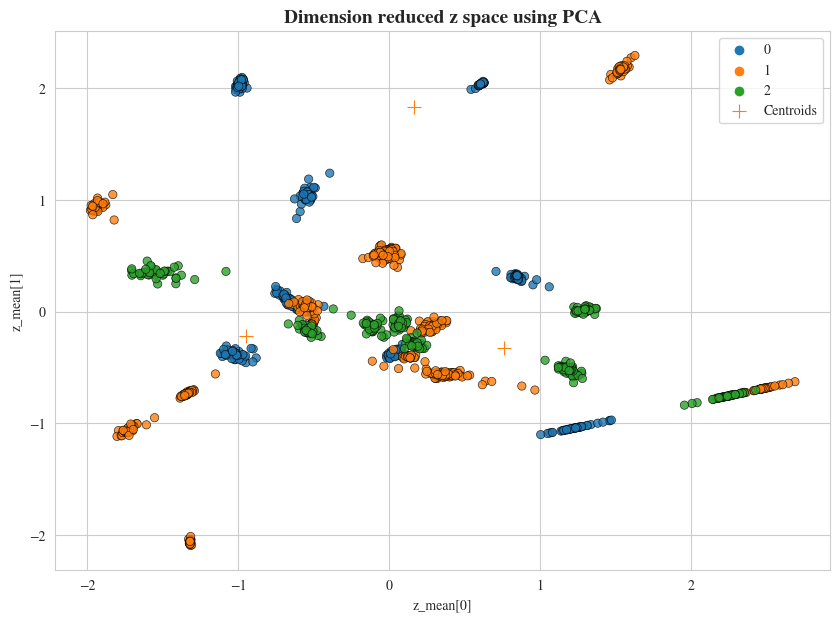

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using PCA", fontweight="bold", size=14)
sns.scatterplot(x=z_dim_reduced_pca[:,0], y=z_dim_reduced_pca[:,1], ax=ax, edgecolor="black", alpha=.8, hue=classes[:,0], palette="tab10")
sns.scatterplot(x=centroids[:,0], y=centroids[:, 1], marker="+", label="Centroids", s=100, edgecolor="black")
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

In [62]:
# Pick a Sample and recounstruct
sample_z_mean = np.array([[0, 0]])
sample_z_mean = pca.inverse_transform(sample_z_mean)

In [63]:
sample_z_mean_reconstructed = vae.decoder(sample_z_mean)

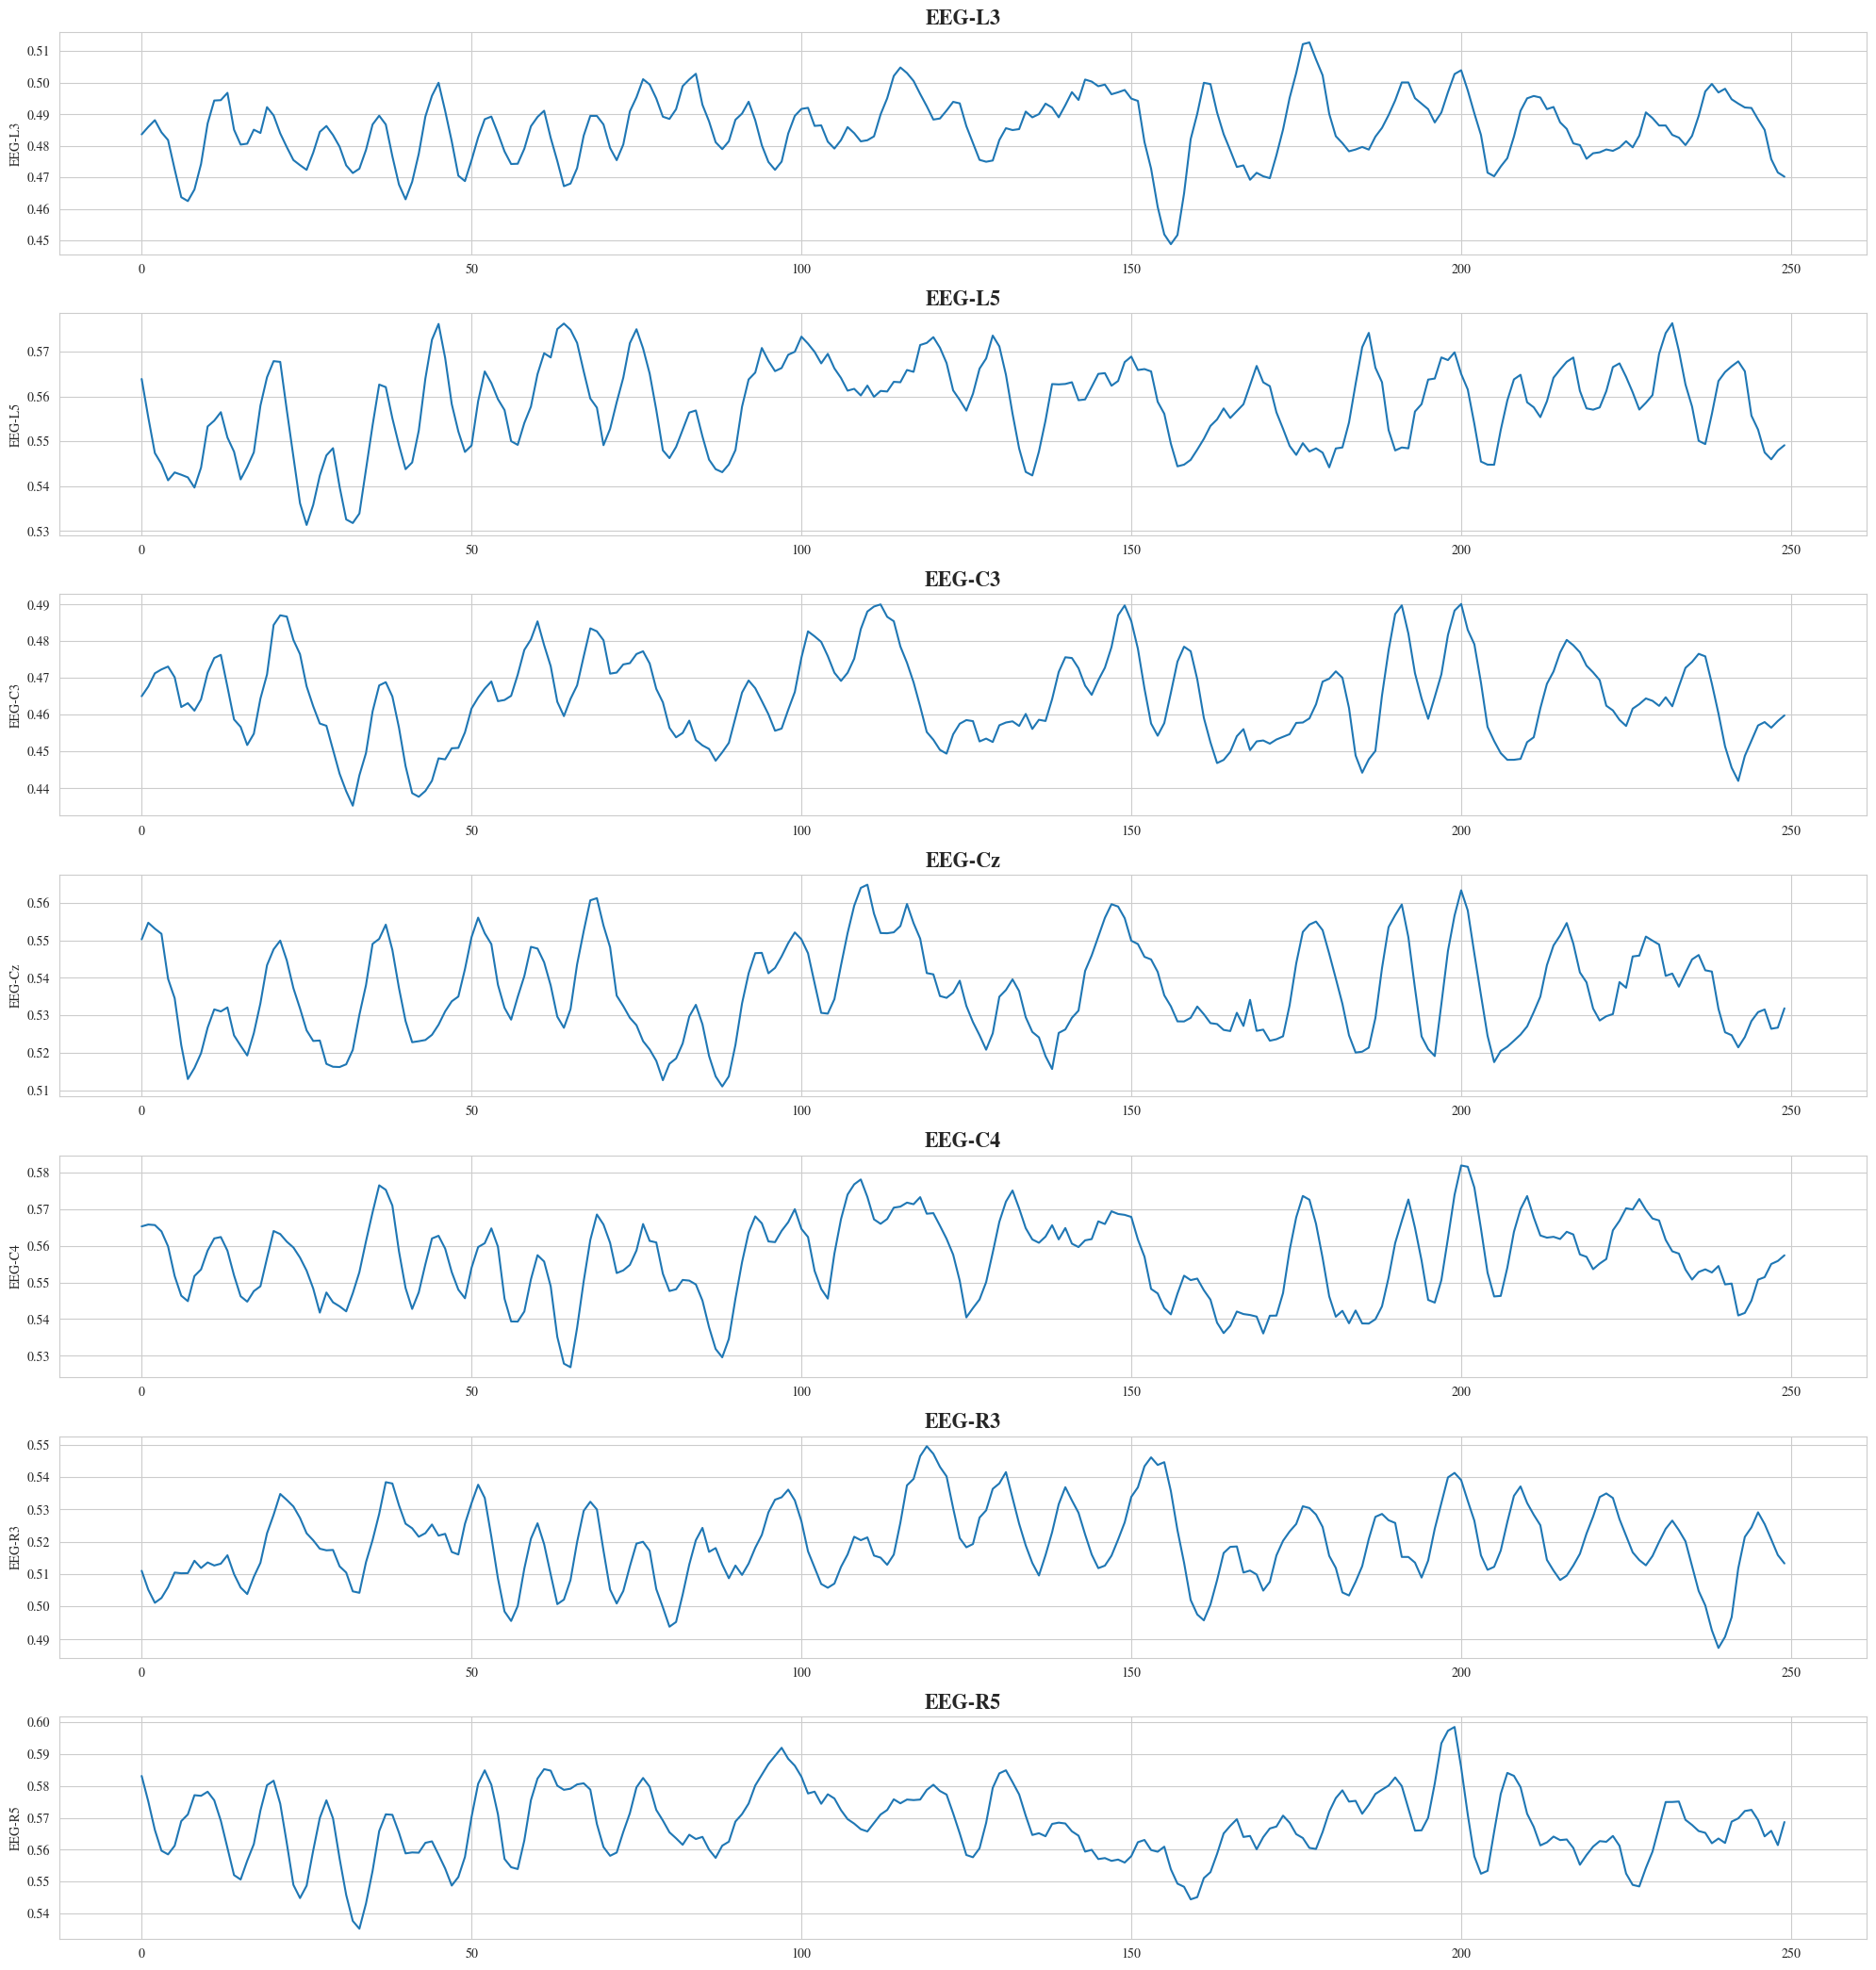

In [64]:
plot_all_time_series(sample_z_mean_reconstructed[0])

## Visualize Clusters

In [65]:
centroid_reconstructed = pca.inverse_transform(centroids)

In [66]:
samples_from_centroids = vae.decoder(centroid_reconstructed)

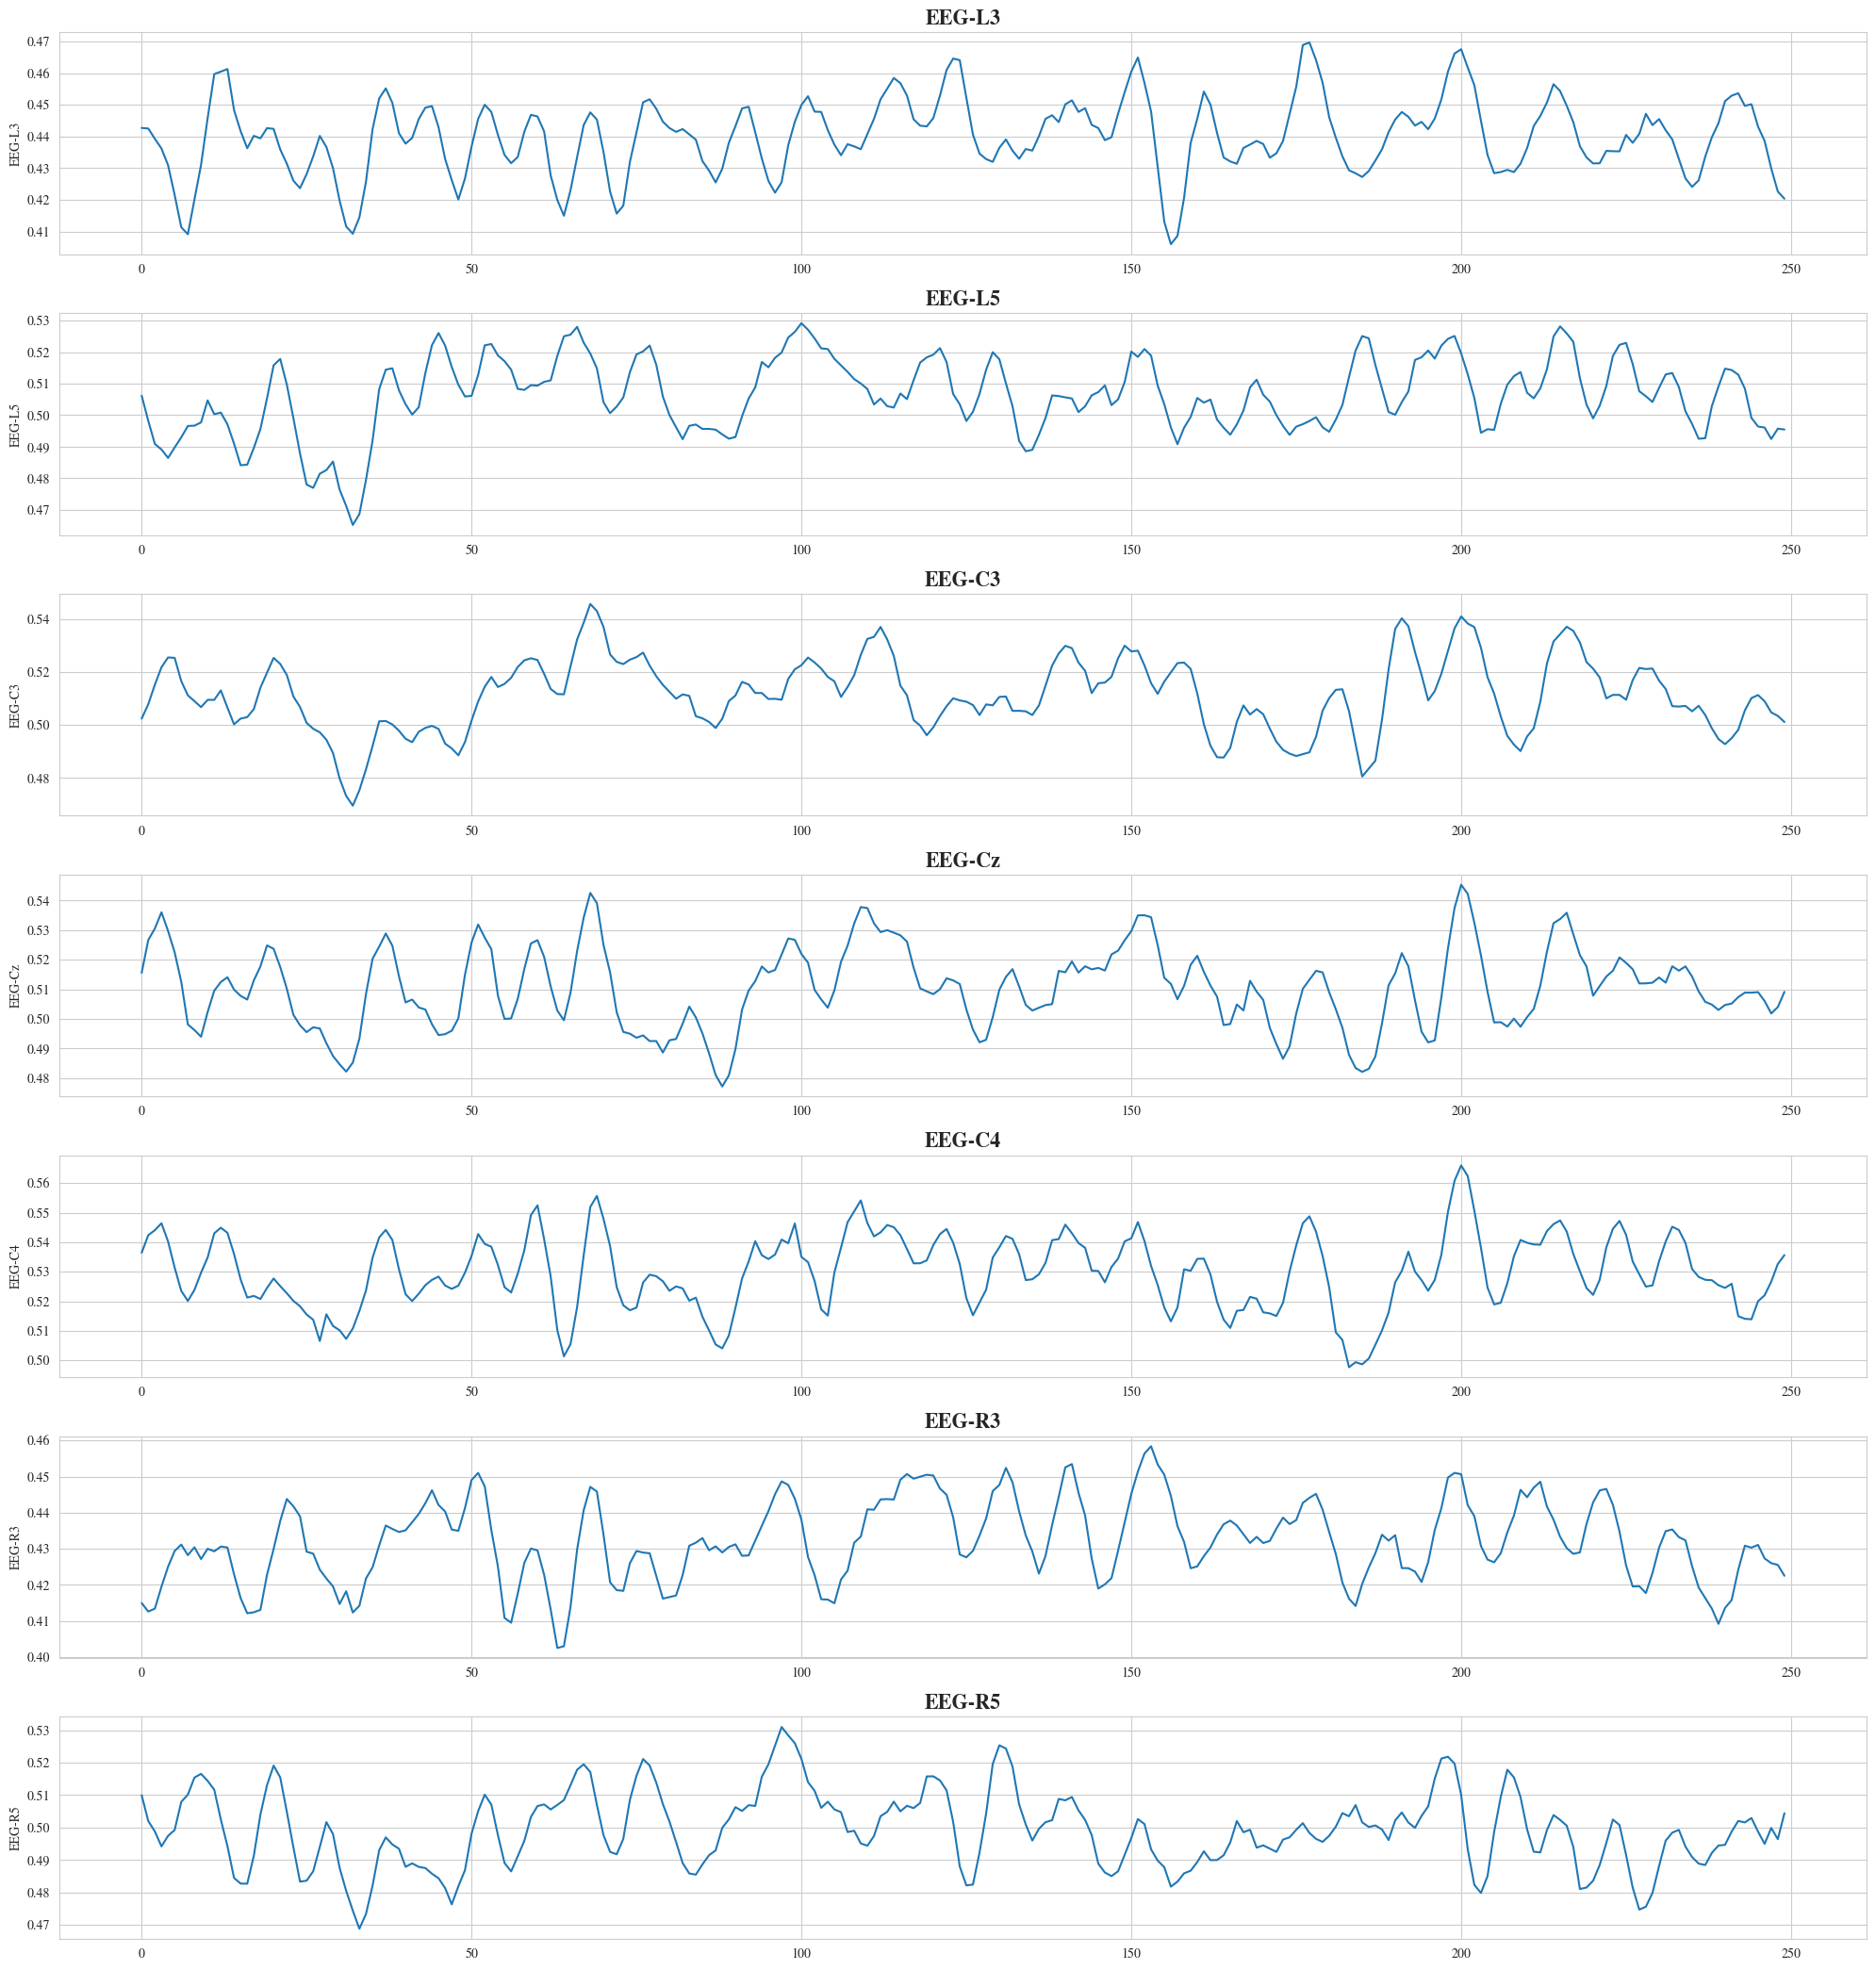

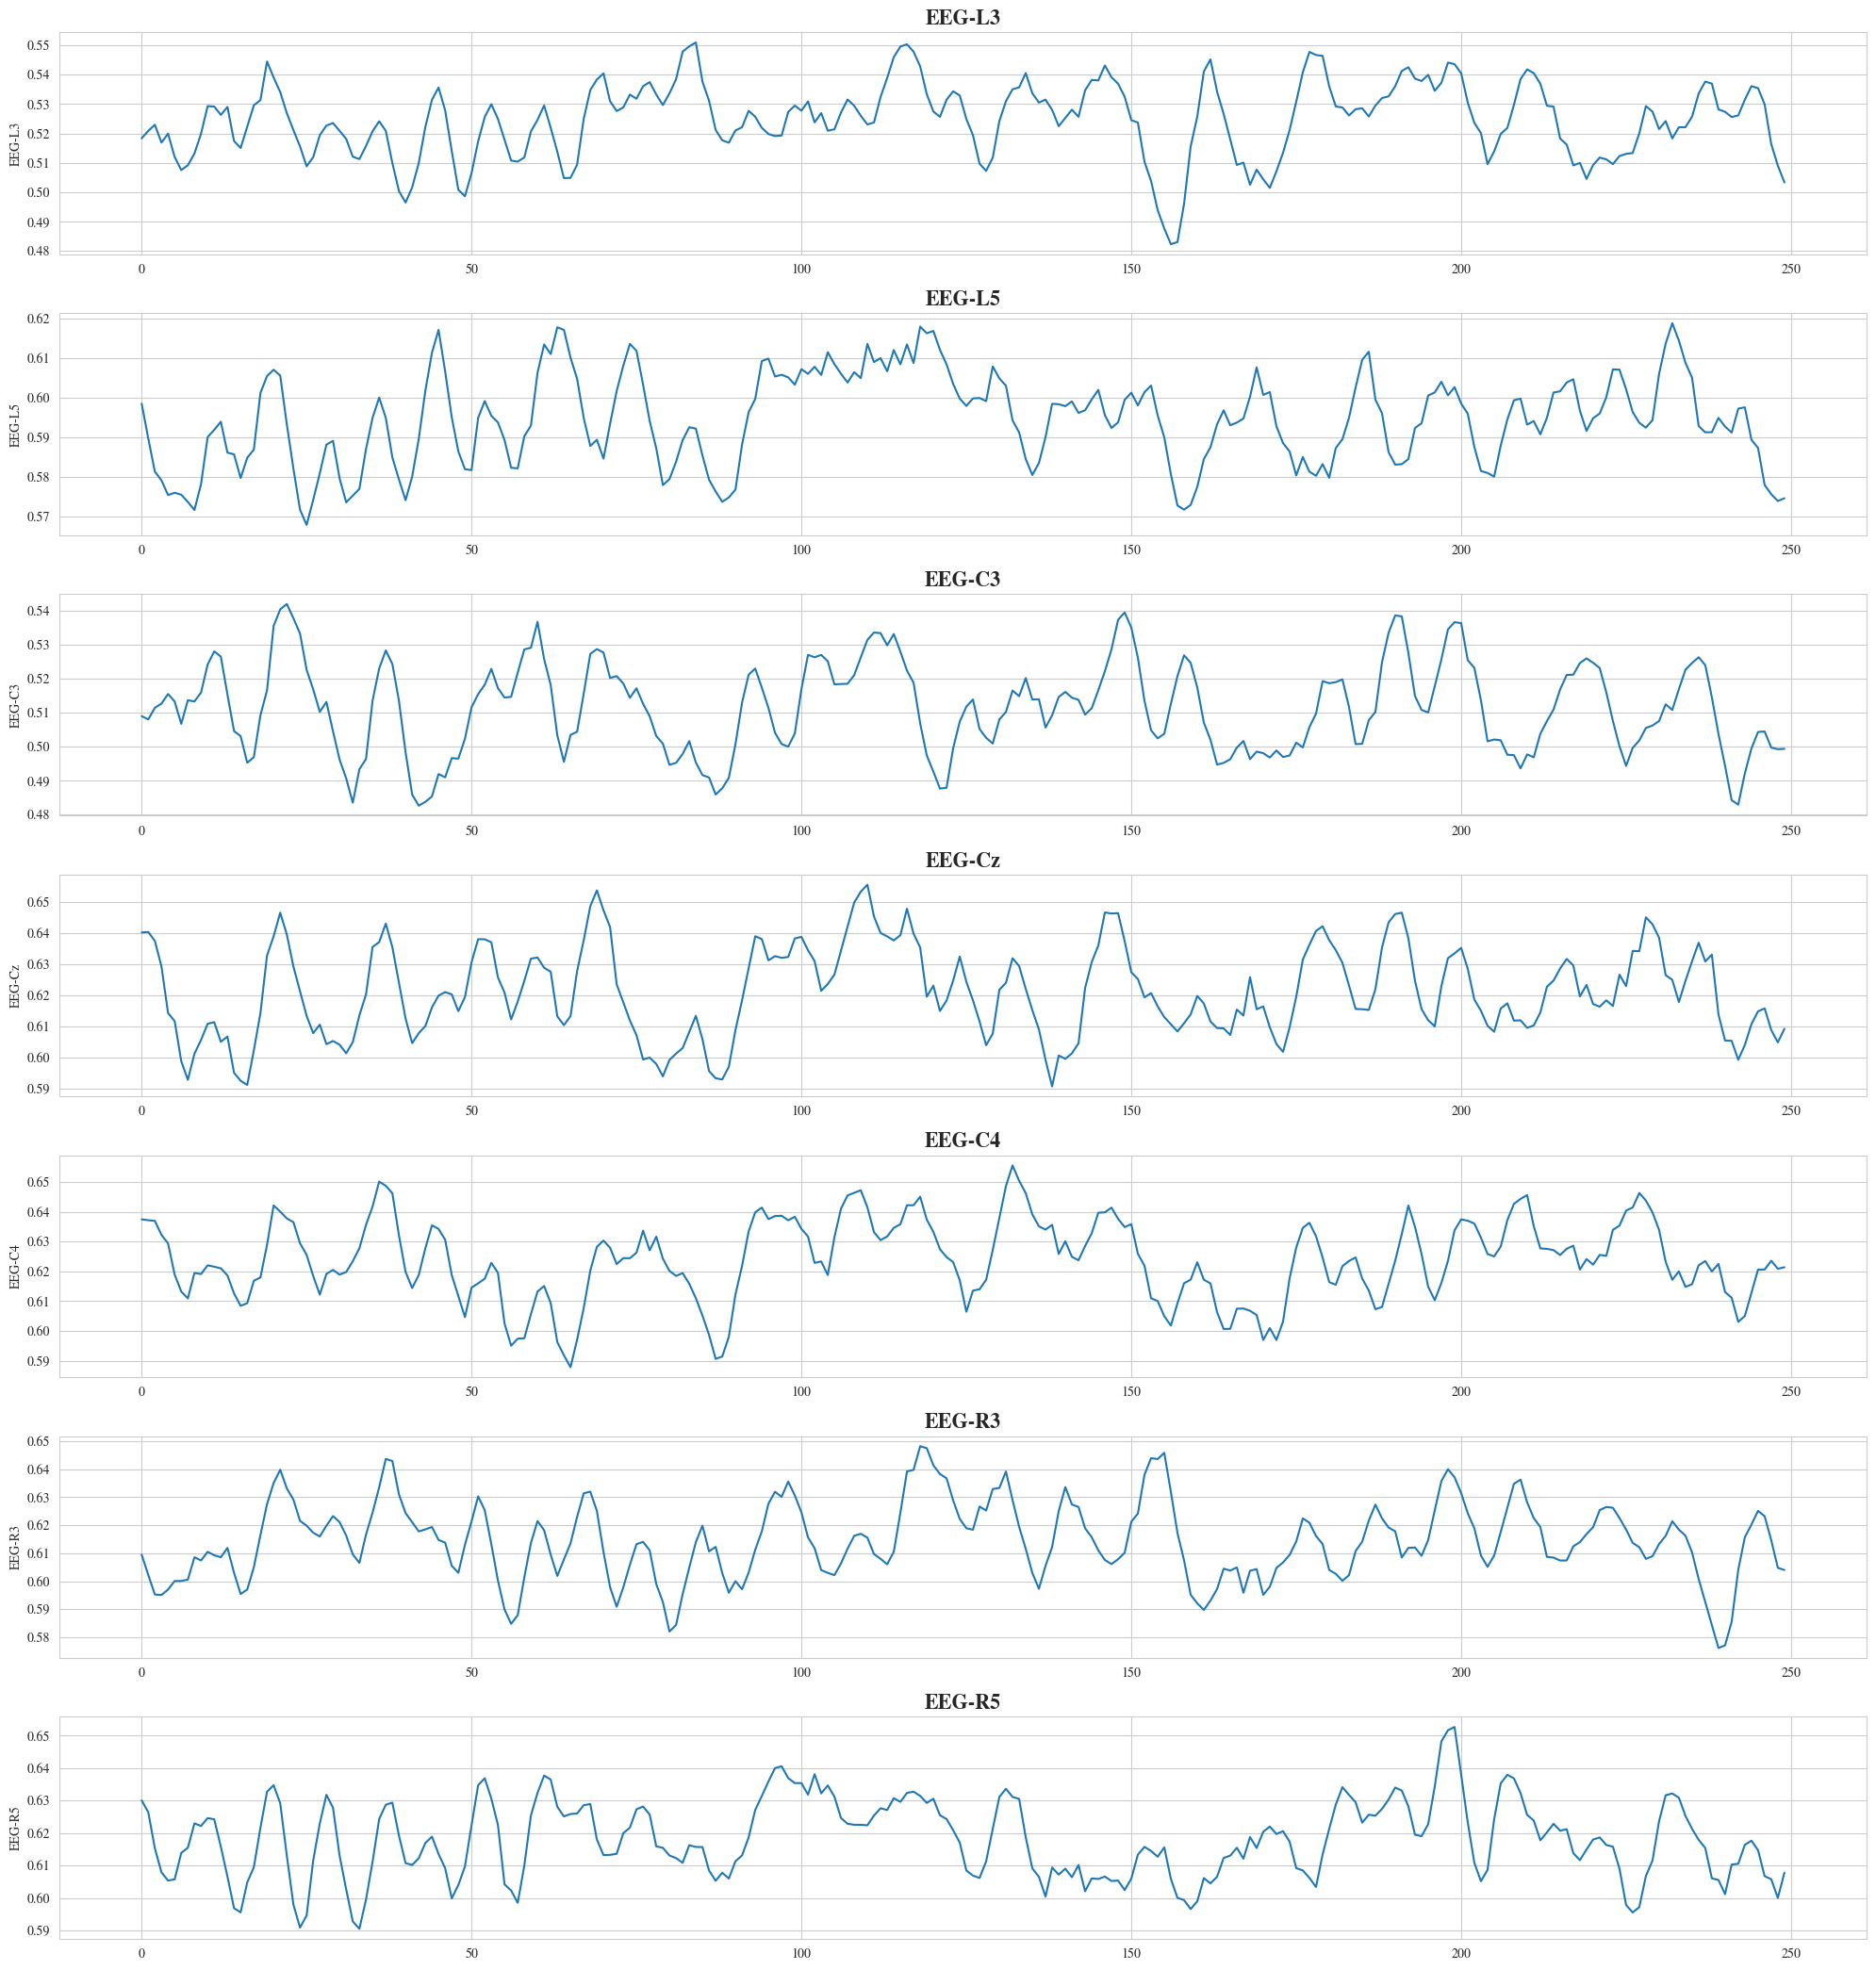

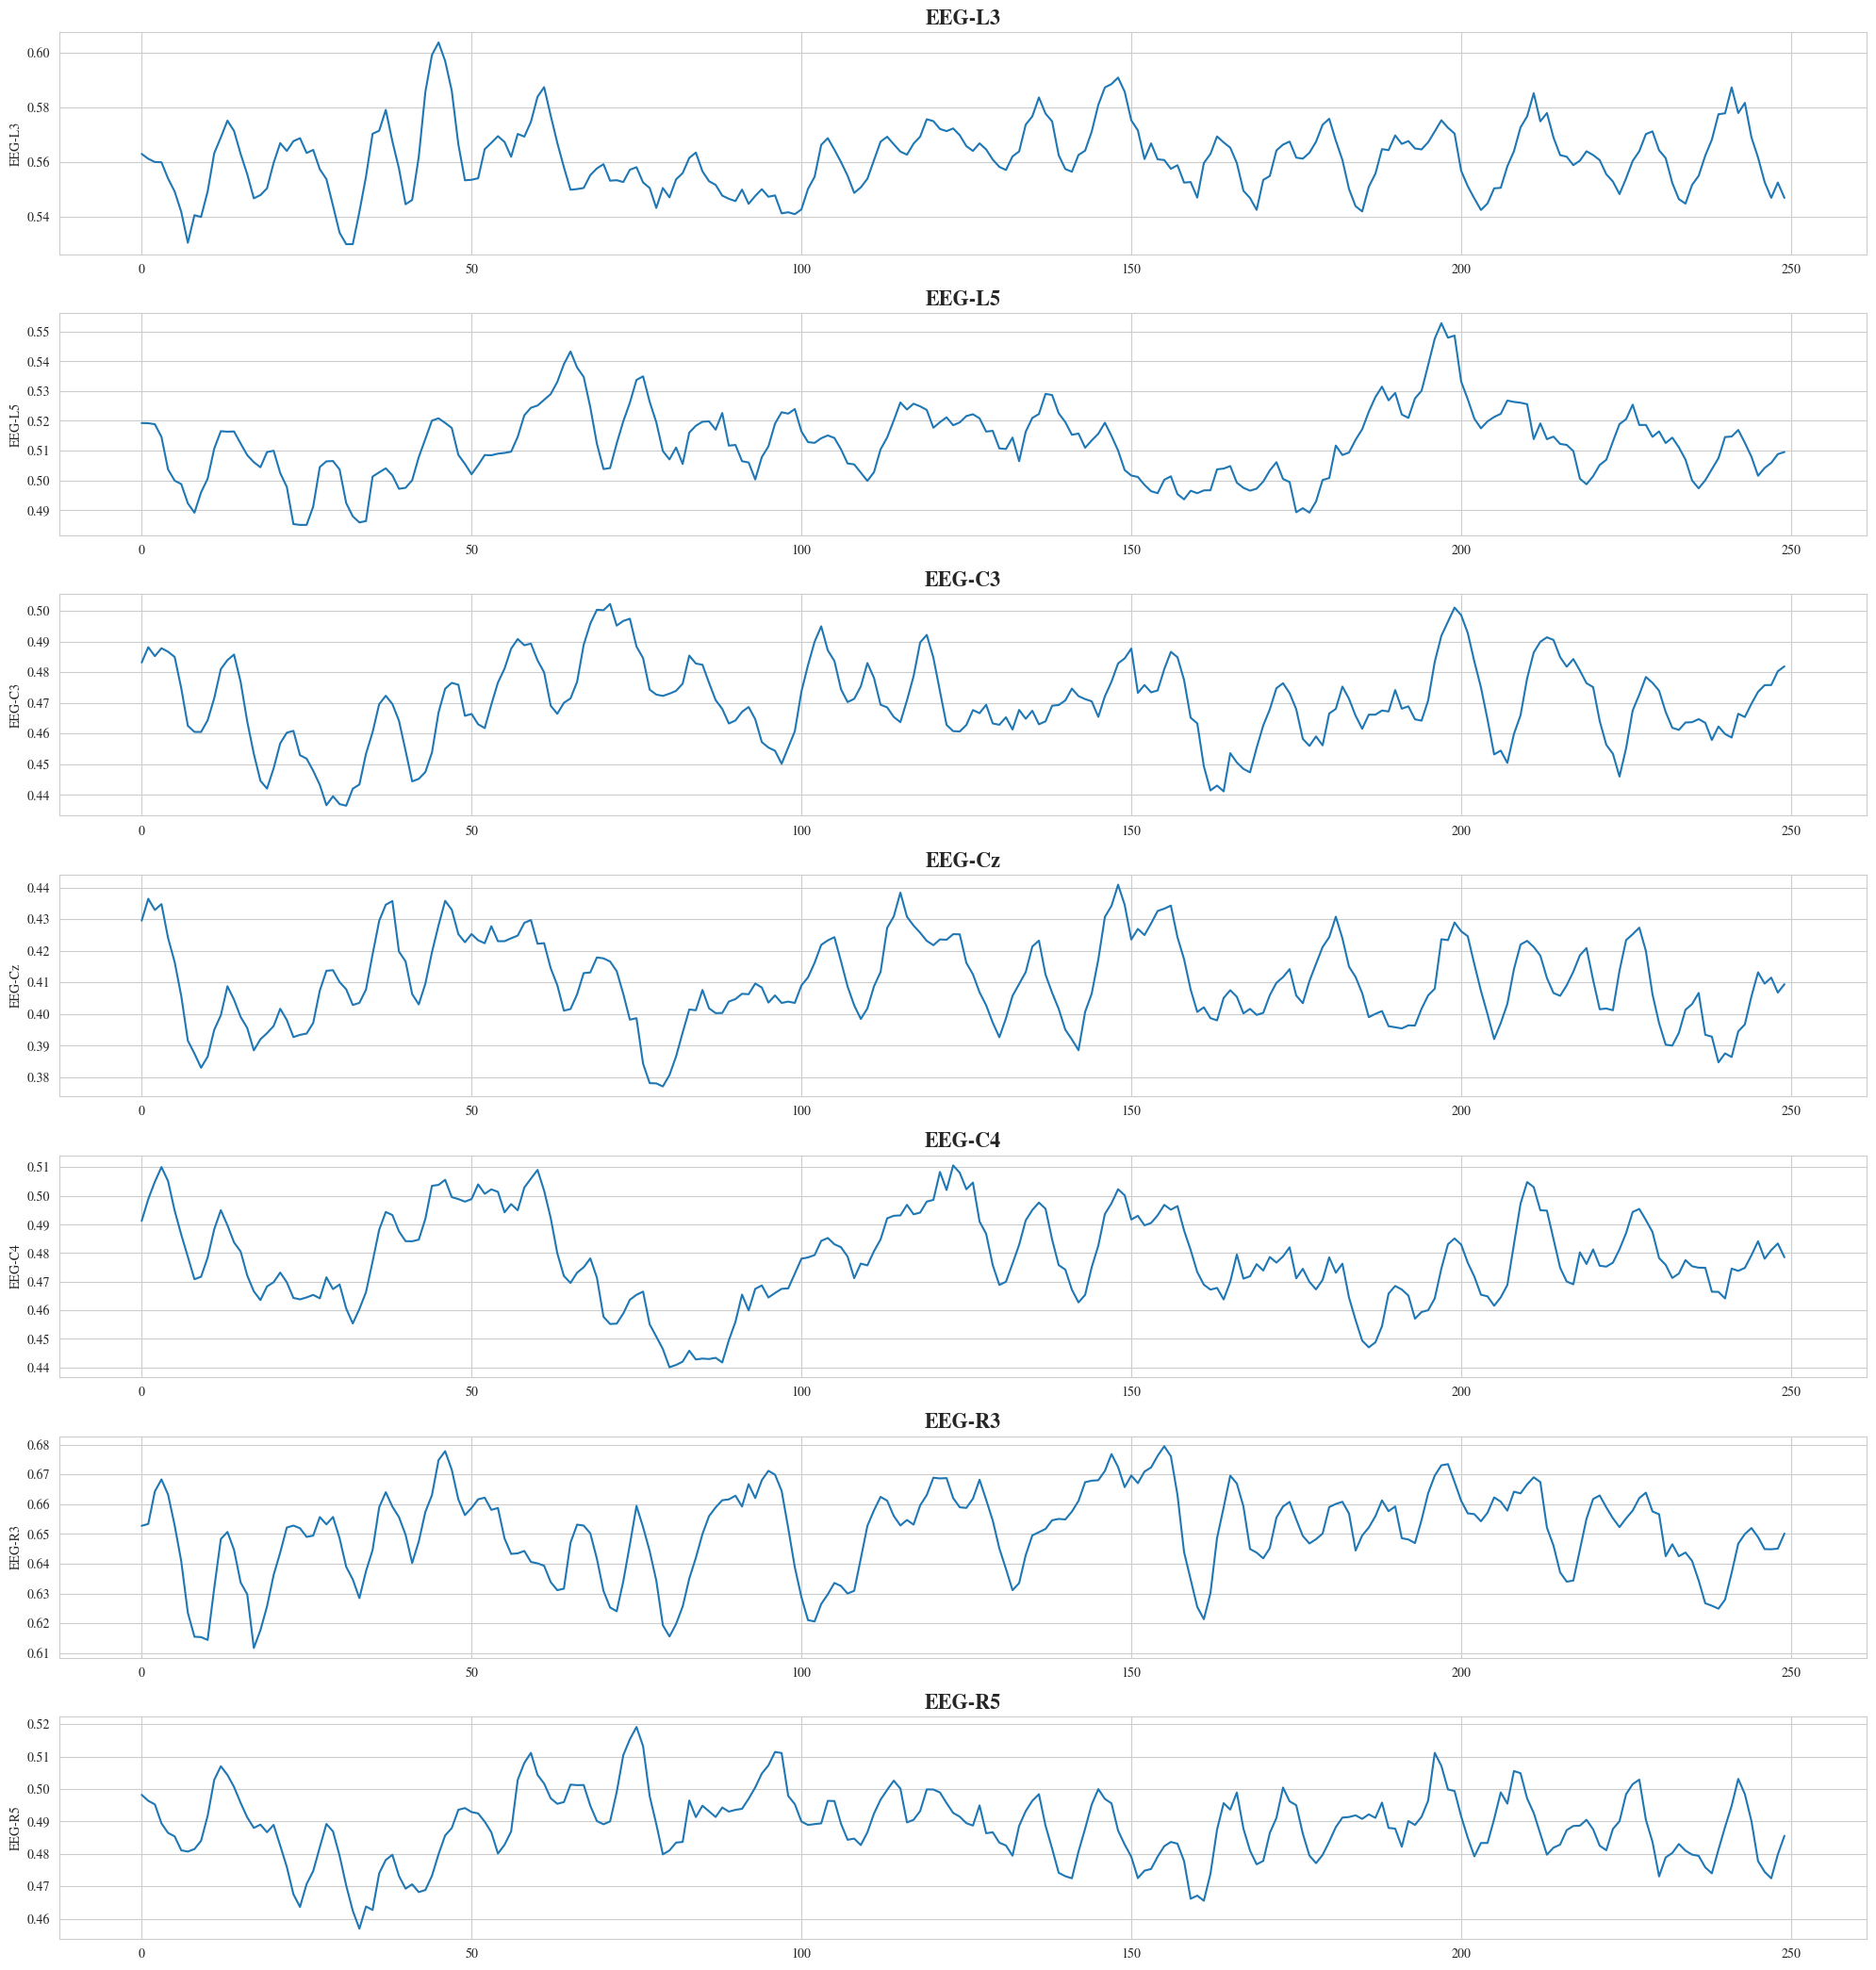

In [67]:
for i in range(samples_from_centroids.shape[0]):
    plot_all_time_series(samples_from_centroids[i])